# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [ ]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

In [3]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# PART 1: Data Generation

GROUP_NUMBER = 1
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    X = (torch.rand(n_samples, 2) * 10) - 5
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # 5% noise
    n_noise = int(0.05 * n_samples)
    idx = torch.randperm(n_samples)[:n_noise]
    y[idx] = 1 - y[idx]

    return X, y

X_full, y_full = generate_data()


In [5]:
# PART 2: Train / Validation Split

n_train = int(0.7 * len(X_full))
indices = torch.randperm(len(X_full))

train_idx = indices[:n_train]
val_idx = indices[n_train:]

X_train, y_train = X_full[train_idx], y_full[train_idx]
X_val, y_val = X_full[val_idx], y_full[val_idx]


In [6]:
# Part3: Model Parameters

def init_weights(in_dim, out_dim):
    return torch.randn(in_dim, out_dim) * 0.1

W1 = init_weights(2, 16);  b1 = torch.zeros(1, 16)
W2 = init_weights(16, 16); b2 = torch.zeros(1, 16)
W3 = init_weights(16, 16); b3 = torch.zeros(1, 16)
W4 = init_weights(16, 1);  b4 = torch.zeros(1, 1)

params = [W1, b1, W2, b2, W3, b3, W4, b4]
for p in params:
    p.requires_grad = True


In [7]:
# PART 4: Activation & Loss

def relu(x):
    return torch.clamp(x, min=0)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def binary_cross_entropy(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    return -(y_true * torch.log(y_pred) +
             (1 - y_true) * torch.log(1 - y_pred)).mean()


In [8]:
# PART 5: Forward Pass

def forward(X):
    z1 = relu(X @ W1 + b1)
    z2 = relu(z1 @ W2 + b2)
    z3 = relu(z2 @ W3 + b3)
    out = sigmoid(z3 @ W4 + b4)
    return out


In [9]:
# PART 6: Training

lr = 0.01
epochs = 200

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):

    # TRAIN
    y_pred = forward(X_train)
    loss = binary_cross_entropy(y_pred, y_train)
    loss.backward()

    with torch.no_grad():
        for p in params:
            p -= lr * p.grad
            p.grad.zero_()

    # accuracy
    train_accuracy = ((y_pred > 0.5) == y_train).float().mean()

    # VALIDATION
    with torch.no_grad():
        y_val_pred = forward(X_val)
        v_loss = binary_cross_entropy(y_val_pred, y_val)
        val_accuracy = ((y_val_pred > 0.5) == y_val).float().mean()

    train_loss.append(loss.item())
    val_loss.append(v_loss.item())
    train_acc.append(train_accuracy.item())
    val_acc.append(val_accuracy.item())

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss {loss:.4f} | Val Loss {v_loss:.4f}")


Epoch 0 | Loss 0.6932 | Val Loss 0.6932
Epoch 20 | Loss 0.6915 | Val Loss 0.6912
Epoch 40 | Loss 0.6900 | Val Loss 0.6895
Epoch 60 | Loss 0.6887 | Val Loss 0.6879
Epoch 80 | Loss 0.6875 | Val Loss 0.6864
Epoch 100 | Loss 0.6864 | Val Loss 0.6851
Epoch 120 | Loss 0.6854 | Val Loss 0.6839
Epoch 140 | Loss 0.6845 | Val Loss 0.6829
Epoch 160 | Loss 0.6837 | Val Loss 0.6819
Epoch 180 | Loss 0.6830 | Val Loss 0.6810


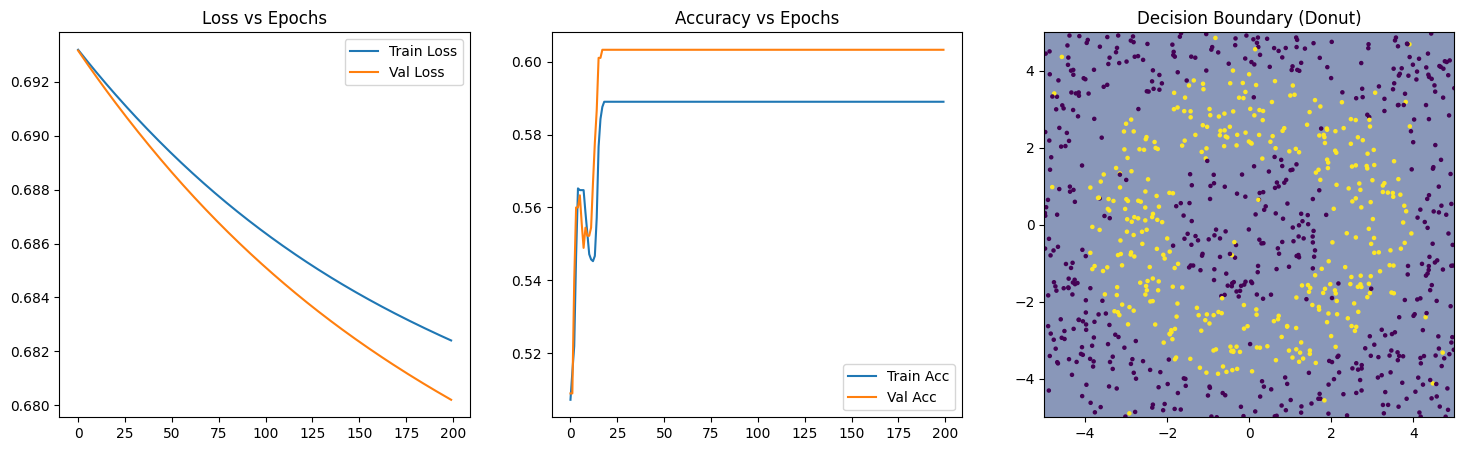

In [10]:
# PART 7: Visualization

plt.figure(figsize=(18, 5))

# 1️ Loss Plot
plt.subplot(1, 3, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss vs Epochs")

# 2️ Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy vs Epochs")

# 3️ Decision Boundary
xx, yy = torch.meshgrid(
    torch.linspace(-5, 5, 300),
    torch.linspace(-5, 5, 300),
    indexing="ij"
)
grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zz = forward(grid).reshape(xx.shape)

plt.subplot(1, 3, 3)
plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], alpha=0.6)
plt.scatter(X_val[:,0], X_val[:,1], c=y_val.squeeze(), s=5)
plt.title("Decision Boundary (Donut)")
plt.show()
